CNN Classifier using basic classification with keras 

In [3]:
import  numpy as np
from sklearn.model_selection import train_test_split
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

2024-12-04 22:24:00.808654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 22:24:00.809069: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 22:24:00.811621: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 22:24:00.818434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733331240.830080  127934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733331240.83

In [4]:
import pathlib

# Specify the path to your custom dataset
data_dir = pathlib.Path('/home/hari07/workspace/intern/anomaly_detection_test_data/anomaly_detection_test_data')

# Verify that the path exists
if not data_dir.exists():
    raise ValueError(f"Dataset directory {data_dir} does not exist. Please check the path.")
    
print(f"Dataset directory: {data_dir}")


Dataset directory: /home/hari07/workspace/intern/anomaly_detection_test_data/anomaly_detection_test_data


In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

print("Train and validation datasets are ready!")

Found 5184 files belonging to 2 classes.
Using 4148 files for training.
Found 5184 files belonging to 2 classes.
Using 1036 files for validation.
Train and validation datasets are ready!


2024-12-04 22:24:02.180807: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


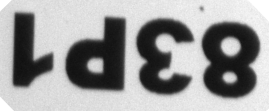

In [6]:
good = list(data_dir.glob('good/*'))
PIL.Image.open(str(good[0]))

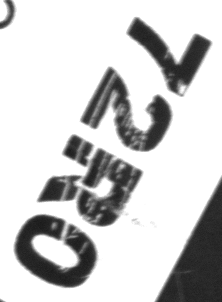

In [7]:
bad = list(data_dir.glob('bad/*'))
PIL.Image.open(str(bad[0]))

In [8]:
class_names = train_dataset.class_names
print(class_names)

['bad', 'good']


2024-12-04 22:24:02.522706: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


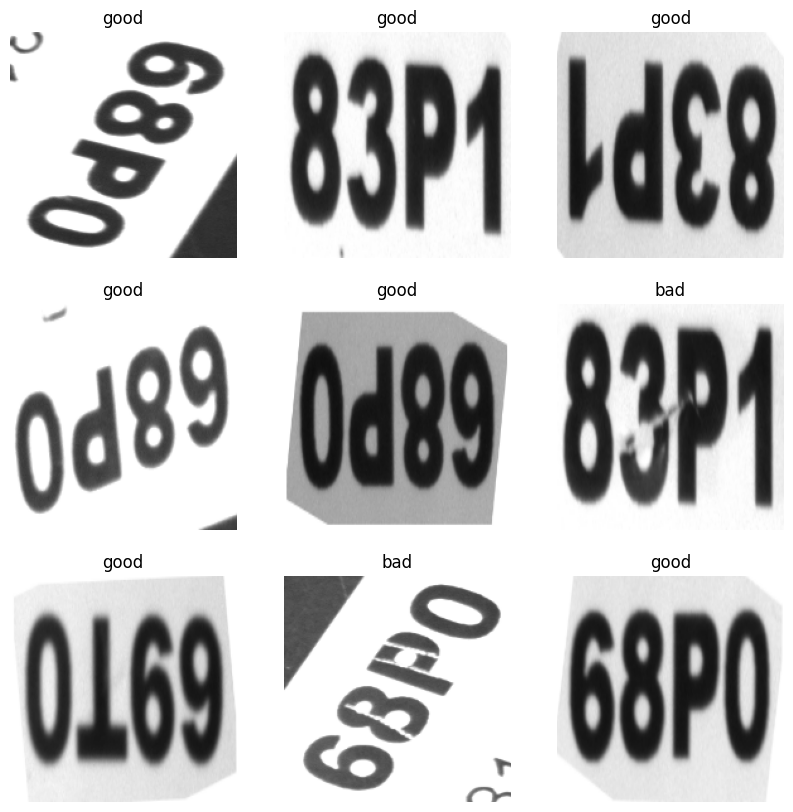

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
normalization_layer = layers.Rescaling(1./255)

In [26]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.3939651 1.0


In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/hari07/workspace/intern/open-cv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7613 - loss: 0.6909 - val_accuracy: 0.8658 - val_loss: 0.3322
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.8452 - loss: 0.3356 - val_accuracy: 0.8842 - val_loss: 0.2709
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9059 - loss: 0.2457 - val_accuracy: 0.9218 - val_loss: 0.1990
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9183 - loss: 0.2091 - val_accuracy: 0.9199 - val_loss: 0.2043
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9397 - loss: 0.1484 - val_accuracy: 0.9344 - val_loss: 0.1705
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.9631 - loss: 0.1121 - val_accuracy: 0.9498 - val_loss: 0.1530
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9716 - loss: 0.0806 - val_accuracy: 0.9537 - val_loss: 0.1413
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9814 - loss: 0.

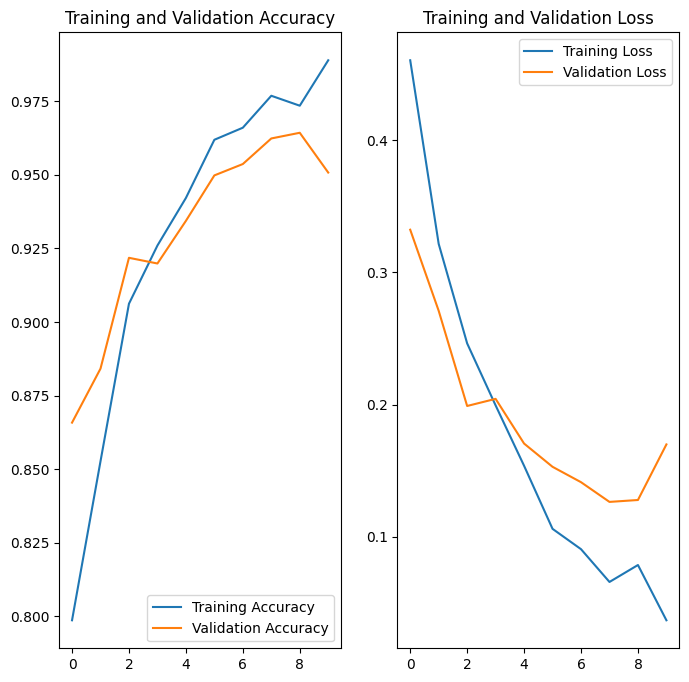

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
# Save in the SavedModel format (default)
model.save('/home/hari07/workspace/intern/CNN_Classifier/cnn.keras')

# Save in HDF5 format
model.save('/home/hari07/workspace/intern/CNN_Classifier/cnn.h5')

In [83]:
test_data_dir = pathlib.Path('/home/hari07/workspace/intern/Dataseprator/test')

# Verify that the path exists
if not test_data_dir.exists():
    raise ValueError(f"Dataset directory {test_data_dir} does not exist. Please check the path.")
    
print(f"Dataset directory: {test_data_dir}")

# Assuming class_names is defined as the list of classes your model predicts
class_names = ["good", "bad"]  # Update this list based on your model's class names

img_height = 180  # Set your image height
img_width = 180   # Set your image width

# Iterate through each subdirectory ("good" and "bad")
for class_dir in test_data_dir.iterdir():
    if class_dir.is_dir():  # Process only directories
        print(f"\nProcessing directory: {class_dir.name}")

        # Iterate through each image file in the subdirectory
        for image_file in class_dir.glob('*'):
            if image_file.is_file():  # Ensure it's a file
                # Load and preprocess the image
                img = tf.keras.utils.load_img(
                    image_file, target_size=(img_height, img_width)
                )
                img_array = tf.keras.utils.img_to_array(img)
                img_array = tf.expand_dims(img_array, 0)  # Create a batch

                # Make predictions
                predictions = model.predict(img_array)
                score = tf.nn.softmax(predictions[0])

                # Print the result
                print(
                    "Image: {} -> Predicted as '{}' with {:.2f}% confidence."
                    .format(image_file.name, class_names[np.argmax(score)], 100 * np.max(score))
                )

Dataset directory: /home/hari07/workspace/intern/Dataseprator/test

Processing directory: good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: 05_08_2024_11_39_26.295661_classifier_input.png -> Predicted as 'bad' with 99.99% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: 29_08_2024_17_03_53.006860_cls_input.png -> Predicted as 'bad' with 87.69% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: 27_08_2024_17_19_14.051706_cls_input.png -> Predicted as 'bad' with 99.96% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: 24_08_2024_18_12_08.127029_cls_input.png -> Predicted as 'bad' with 100.00% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: 28_08_2024_11_56_21.043907_cls_input.png -> Predicted as 'bad' with 100.00% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: 14_10_2024_13_00_10.174826_cls_input.png -> Predicted as 'bad' with 100.00% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: 23_09_2024_11_14_12.107822_cls_input.png -> Predicted as '

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f14542083b0>

**Testing with new data**

In [85]:
image_path="/home/hari07/workspace/intern/Dataseprator/train/bad/09_08_2024_18_08_30.356149_classifier_input.png"

img_height = 180
img_width = 180

# Load and preprocess the image
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make a prediction
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Assuming `class_names` is defined as the list of your class names
class_names = ["bad", "good"]  # Update to match your model's class names

# Print the prediction
print(
    "This image most likely belongs to '{}' with {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to 'bad' with 96.58% confidence.
